In [1]:
%load_ext autoreload
%autoreload 2

# Testing _crossfit Function

In [2]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from econml._ortho_learner import _crossfit

class Wrapper:
    def __init__(self, model):
        self._model = model
    def fit(self, X, y, W=None):
        self._model.fit(X, y)
        return self
    def predict(self, X, y, W=None):
        return self._model.predict(X)
np.random.seed(123)
X = np.random.normal(size=(5000, 3))
y = X[:, 0] + np.random.normal(size=(5000,))
folds = list(KFold(2).split(X, y))
model = Lasso(alpha=0.01)
nuisance, model_list, fitted_inds = _crossfit(Wrapper(model),
                                 folds,
                                 X, y, W=y, Z=None)
print(nuisance)
print(model_list)
fitted_inds

(array([-1.1057289 , -1.53756637, -2.4518278 , ...,  1.10628792,
       -1.82966233, -1.78227335]),)
[<__main__.Wrapper object at 0x0000019E364CCAC8>, <__main__.Wrapper object at 0x0000019E390CA438>]


array([   0,    1,    2, ..., 4997, 4998, 4999])

# Simple DML with the _OrthoLearner

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from econml._ortho_learner import _OrthoLearner
class ModelNuisance:
    def __init__(self, model_t, model_y):
        self._model_t = model_t
        self._model_y = model_y
    def fit(self, Y, T, W=None):
        self._model_t.fit(W, T)
        self._model_y.fit(W, Y)
        return self
    def predict(self, Y, T, W=None):
        return Y - self._model_y.predict(W), T - self._model_t.predict(W)
class ModelFinal:
    def __init__(self):
        return
    def fit(self, Y, T, W=None, nuisances=None):
        Y_res, T_res = nuisances
        self.model = LinearRegression(fit_intercept=False).fit(T_res.reshape(-1, 1), Y_res)
        return self
    def predict(self, X=None):
        return self.model.coef_[0]
    def score(self, Y, T, W=None, nuisances=None):
        Y_res, T_res = nuisances
        return np.mean((Y_res - self.model.predict(T_res.reshape(-1, 1)))**2)
np.random.seed(123)
X = np.random.normal(size=(100, 3))
y = X[:, 0] + X[:, 1] + np.random.normal(0, 0.1, size=(100,))
est = _OrthoLearner(ModelNuisance(LinearRegression(), LinearRegression()),
                    ModelFinal(),
                    n_splits=2, discrete_treatment=False, random_state=None)
est.fit(y, X[:, 0], W=X[:, 1:])

In [4]:
est.const_marginal_effect()

1.0236499258047582

In [5]:
est.effect(T0=0, T1=1)

array([1.02364993])

In [6]:
est.score(y, X[:, 0], W=X[:, 1:])

0.00727995424098179

In [7]:
est.model_final.model

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [8]:
est.model_final.model.coef_

array([1.02364993])

In [9]:
est.score_

0.007568302109999713

# Simple DML with Discrete Treatments with the _OrthoLearner

In [10]:
class ModelNuisance:
    def __init__(self, model_t, model_y):
        self._model_t = model_t
        self._model_y = model_y

    def fit(self, Y, T, W=None):
        self._model_t.fit(W, np.matmul(T, np.arange(1, T.shape[1]+1)))
        self._model_y.fit(W, Y)
        return self

    def predict(self, Y, T, W=None):
        return Y - self._model_y.predict(W), T - self._model_t.predict_proba(W)[:, 1:]

class ModelFinal:

    def __init__(self):
        return

    def fit(self, Y, T, W=None, nuisances=None):
        Y_res, T_res = nuisances
        self.model = LinearRegression(fit_intercept=False).fit(T_res.reshape(-1, 1), Y_res)
        return self

    def predict(self):
        # theta needs to be of dimension (1, d_t) if T is (n, d_t)
        return np.array([[self.model.coef_[0]]])

    def score(self, Y, T, W=None, nuisances=None):
        Y_res, T_res = nuisances
        return np.mean((Y_res - self.model.predict(T_res.reshape(-1, 1)))**2)

np.random.seed(123)
X = np.random.normal(size=(100, 3))
import scipy.special
from sklearn.linear_model import LogisticRegression
T = np.random.binomial(1, scipy.special.expit(X[:, 0]))
sigma = 0.01
y = T + X[:, 0] + np.random.normal(0, sigma, size=(100,))
est = _OrthoLearner(ModelNuisance(LogisticRegression(solver='lbfgs'), LinearRegression()), ModelFinal(),
                    n_splits=2, discrete_treatment=True, random_state=None)
est.fit(y, T, W=X)

In [11]:
est.const_marginal_effect()

array([[1.00123159]])

In [12]:
est.effect()

array([1.00123159])

In [13]:
est.score(y, T, W=X)

0.002569588332146636

In [14]:
est.model_final.model.coef_[0]

1.0012315874866915

In [15]:
est.model_final.model

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [16]:
est.model_final.model.coef_

array([1.00123159])

In [17]:
est.score_

0.00316040597083645

In [18]:
est.models_nuisance[0]._model_y.coef_

array([1.28171346, 0.03749846, 0.10120681])

# Simple DML with the _RLearner

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression
from econml._rlearner import _RLearner
from sklearn.base import clone
class ModelFirst:
    def __init__(self, model):
        self._model = clone(model, safe=False)
    def fit(self, X, W, Y, sample_weight=None):
        self._model.fit(np.hstack([X, W]), Y)
        return self
    def predict(self, X, W):
        return self._model.predict(np.hstack([X, W]))
class ModelFinal:
    def fit(self, X, T_res, Y_res, sample_weight=None, sample_var=None):
        self.model = LinearRegression(fit_intercept=False).fit(X * T_res.reshape(-1, 1), Y_res)
        return self
    def predict(self, X):
        return self.model.predict(X)
np.random.seed(123)
X = np.random.normal(size=(1000, 3))
y = X[:, 0] + X[:, 1] + np.random.normal(0, 0.01, size=(1000,))
est = _RLearner(ModelFirst(LinearRegression()),
                ModelFirst(LinearRegression()),
                ModelFinal(),
                n_splits=2, discrete_treatment=False, random_state=None)
est.fit(y, X[:, 0], X=np.ones((X.shape[0], 1)), W=X[:, 1:])

In [20]:
est.const_marginal_effect(np.ones((1,1)))

array([0.99963147])

In [21]:
est.effect(np.ones((1,1)), T0=0, T1=10)

array([9.99631472])

In [22]:
est.score(y, X[:, 0], X=np.ones((X.shape[0], 1)), W=X[:, 1:])

9.736380060274927e-05

In [23]:
est.model_final.model

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [24]:
est.model_final.model.coef_

array([0.99963147])

In [25]:
est.score_

9.826232040878261e-05

In [26]:
[mdl._model for mdl in est.models_y]

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False)]

In [27]:
[mdl._model for mdl in est.models_t]

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False)]

# Checking All Good with LinearDMLCateEstimator

In [28]:
from econml.dml import LinearDMLCateEstimator

np.random.seed(123)
X = np.random.normal(size=(1000, 3))
y = X[:, 0] + X[:, 1] + np.random.normal(0, 0.01, size=(1000,))
est = LinearDMLCateEstimator(model_y=LinearRegression(),
                             model_t=LinearRegression())
est.fit(y, X[:, 0], W=X[:, 1:], inference='statsmodels')

In [29]:
est.effect()

array([0.99943203])

In [30]:
est.effect_interval()

(array([0.9959591]), array([1.00290496]))

In [31]:
est.models_y

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False)]

In [32]:
est.models_t

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False)]

In [35]:
est.coef_

array([0.99943203])

In [39]:
est.coef__interval()

(array([0.9959591]), array([1.00290496]))

In [40]:
est.model_final

In [41]:
est.model_final._param_stderr

array([0.00211139])

# DR Learner Based on _OrthoLearner

In [42]:
import numpy as np
from sklearn.linear_model import LinearRegression
from econml._ortho_learner import _OrthoLearner
class ModelNuisance:
    def __init__(self, model_t, model_y):
        self._model_t = model_t
        self._model_y = model_y

    def fit(self, Y, T, X=None, W=None):
        self._model_t.fit(np.hstack([X, W]), np.matmul(T, np.arange(1, T.shape[1]+1)))
        self._model_y.fit(np.hstack([T, X, W]), Y)
        return self

    def predict(self, Y, T, X=None, W=None):
        propensities = self._model_t.predict_proba(np.hstack([X, W]))
        Y_pred = np.zeros((T.shape[0], T.shape[1] + 1))
        T_counter = np.zeros(T.shape)
        Y_pred[:, 0] = self._model_y.predict(np.hstack([T_counter, X, W]))
        Y_pred[:, 0] += (Y - Y_pred[:, 0]) * np.all(T==0, axis=1) / propensities[:, 0]
        for t in np.arange(T.shape[1]):
            T_counter = np.zeros(T.shape)
            T_counter[:, t] = 1
            Y_pred[:, t + 1] = self._model_y.predict(np.hstack([T_counter, X, W]))
            Y_pred[:, t + 1] += (Y - Y_pred[:, t + 1]) * (T[:, t] == 1) / propensities[:, t + 1]
        return Y_pred

class ModelFinal:

    def __init__(self):
        return

    def fit(self, Y, T, X=None, W=None, nuisances=None):
        Y_pred, = nuisances
        self.models_cate = [LinearRegression().fit(X, Y_pred[:, t] - Y_pred[:, 0])
                            for t in np.arange(1, Y_pred.shape[1])]
        return self

    def predict(self, X=None):
        # theta needs to be of dimension (1, d_t) if T is (n, d_t)
        return np.array([mdl.predict(X) for mdl in self.models_cate]).T

np.random.seed(123)
X = np.random.normal(size=(1000, 3))
import scipy.special
from sklearn.linear_model import LogisticRegression
T = np.random.binomial(1, scipy.special.expit(X[:, 0]))
sigma = 0.01
y = (1 + .5*X[:, 0]) * T + X[:, 0] + np.random.normal(0, sigma, size=(1000,))
est = _OrthoLearner(ModelNuisance(LogisticRegression(solver='lbfgs'), LinearRegression()), ModelFinal(),
                    n_splits=2, discrete_treatment=True, random_state=None)
est.fit(y, T, X=X[:, [0]], W=X[:, 1:])

In [43]:
est.const_marginal_effect(X[:10, [0]])

array([[ 0.43111746],
       [ 0.21377249],
       [-0.26176354],
       [ 0.54421168],
       [ 1.76258919],
       [ 0.76761463],
       [ 1.51079693],
       [ 1.76224943],
       [ 0.34418752],
       [ 0.2538734 ]])

In [44]:
[mdl._model_t.coef_ for mdl in est.models_nuisance]

[array([[ 1.07859458, -0.09378512, -0.16819498]]),
 array([[ 0.87520635, -0.07950399,  0.06037872]])]

In [45]:
[mdl._model_y.coef_ for mdl in est.models_nuisance]

[array([ 0.99703455,  1.25799456, -0.00554411,  0.00216083]),
 array([ 1.04547656e+00,  1.21020962e+00,  7.94069500e-04, -9.68240609e-03])]

In [46]:
est.model_final.models_cate[0].coef_

array([0.51667104])

In [47]:
est.model_final.models_cate[0].intercept_

0.9920313527587242

In [114]:
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV
from econml.drlearner import DRLearner
import scipy.special
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from econml.utilities import StatsModelsLinearRegression

np.random.seed(123)
X = np.random.uniform(-1, 1, size=(1000, 3))
T = np.random.binomial(2, scipy.special.expit(X[:, 0]))
sigma = 0.01
y = (1 + .5*X[:, 0]) * T + X[:, 0] + np.random.normal(0, sigma, size=(1000,))
est = DRLearner(model_propensity=LogisticRegression(solver='lbfgs', multi_class='auto'),
                model_regression=GradientBoostingRegressor(),
                model_final=StatsModelsLinearRegression(),
                featurizer=None,
                multitask_model_final=False)
est.fit(y, T, X=X, W=X)

In [115]:
est.effect(X[:3], T0=0, T1=1)

array([1.1822157 , 1.04007715, 1.45625656])

In [116]:
np.hstack([1 + .5*X[:3, [0]], 2*(1 + .5*X[:3, [0]])])

array([[1.19646919, 2.39293837],
       [1.05131477, 2.10262954],
       [1.4807642 , 2.9615284 ]])

In [117]:
est.const_marginal_effect(X[:3])

array([[1.1822157 , 2.37734235],
       [1.04007715, 2.10080704],
       [1.45625656, 2.92916254]])

In [118]:
est.marginal_effect(1, X[:3])

array([[1.1822157 , 2.37734235],
       [1.04007715, 2.10080704],
       [1.45625656, 2.92916254]])

In [119]:
X[:3]

array([[ 0.39293837, -0.42772133, -0.54629709],
       [ 0.10262954,  0.43893794, -0.15378708],
       [ 0.9615284 ,  0.36965948, -0.0381362 ]])

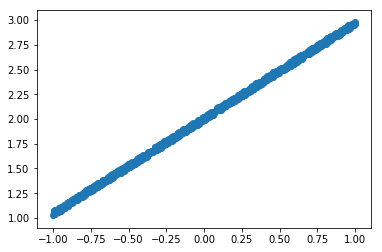

In [120]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], est.effect(X, T0=0, T1=2))
plt.plot(X[np.argsort(X[:, 0]), 0], 2*(1 + .5 * X[np.argsort(X[:, 0]), 0]))
plt.show()

In [121]:
[mdl.feature_importances_ for mdl in est.models_regression]

[array([3.45573897e-01, 3.21178507e-05, 3.08428112e-05, 3.58341961e-01,
        2.43631009e-05, 3.06469831e-05, 7.36212833e-02, 2.22344889e-01]),
 array([4.46383838e-01, 1.49116561e-05, 4.20320308e-05, 2.56714069e-01,
        1.95528781e-05, 5.42082732e-05, 6.68325493e-02, 2.29938839e-01])]

In [122]:
[mdl.coef_ for mdl in est.models_propensity]

[array([[-0.49272048,  0.0145733 ,  0.16088469, -0.49272048,  0.0145733 ,
          0.16088469],
        [-0.14935627, -0.00605934,  0.04036645, -0.14935627, -0.00605934,
          0.04036645],
        [ 0.64207675, -0.00851396, -0.20125114,  0.64207675, -0.00851396,
         -0.20125114]]),
 array([[-0.50834433,  0.10651235,  0.08677571, -0.50834433,  0.10651235,
          0.08677571],
        [ 0.02445202,  0.02195648, -0.10241936,  0.02445202,  0.02195648,
         -0.10241936],
        [ 0.48389231, -0.12846882,  0.01564365,  0.48389231, -0.12846882,
          0.01564365]])]

In [123]:
est.model_cate(T=2).coef_

array([ 0.96136796, -0.00580304,  0.01933087])

In [124]:
est.cate_feature_names(['age', 'gender', 'race'])

['age', 'gender', 'race']

In [125]:
est.model_cate(T=2).intercept_

2.0076622997218885

In [126]:
est.model_cate(T=1).coef_

array([ 0.48337304, -0.00475761,  0.00589065])

In [127]:
est.model_cate(T=1).intercept_

0.9934630032585429

In [128]:
est.score_

0.04512261740711864

In [130]:
est.score(y, T, X=X, W=X)

0.01764000613532899

In [98]:
import numpy as np
import scipy.special
from econml.drlearner import DRLearner, LinearDRLearner
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(123)
X = np.random.normal(size=(1000, 3))
T = np.random.binomial(2, scipy.special.expit(X[:, 0]))
y = (1 + .5*X[:, 0]) * T + X[:, 0] + np.random.normal(size=(1000,))
est = LinearDRLearner(featurizer=PolynomialFeatures(degree=2, include_bias=False))
est.fit(y, T, X=None, W=X, inference='statsmodels')

In [99]:
from econml.utilities import StatsModelsLinearRegression

In [100]:
est.effect_interval()

(array([0.67722687]), array([1.0525938]))

In [101]:
est.intercept_(T=1)

0.8649103357239153

In [102]:
est.model_cate(T=1).coef_

array([], dtype=float64)

In [103]:
low, up = est.const_marginal_effect_interval()

In [104]:
point = est.const_marginal_effect()

In [105]:
for x, l, p, u in zip(X, low, point, up):
    print("X={}".format(x))
    for it, (ll, pp, uu) in enumerate(zip(l, p, u)):
        print(ll, pp, uu)
        print((1 + .5*x[0])*(it+1))

X=[-1.0856306   0.99734545  0.2829785 ]
0.6772268715192845 0.8649103357239153 1.052593799928546
0.4571846983497194
1.6932440708855916 1.9226135780335254 2.151983085181459
0.9143693966994388


In [106]:
est.effect_interval(T0=np.zeros(3), T1=np.array([1, 2, 1]))

(array([0.67722687, 1.69324407, 0.67722687]),
 array([1.0525938 , 2.15198309, 1.0525938 ]))

In [107]:
est.coef__interval(T=2)

(array([], dtype=float64), array([], dtype=float64))

In [108]:
est.intercept__interval(T=2)

(1.6932440708855916, 2.151983085181459)

In [109]:
est.effect_interval()

(array([0.67722687]), array([1.0525938]))

In [110]:
est.const_marginal_effect_interval()

(array([[0.67722687, 1.69324407]]), array([[1.0525938 , 2.15198309]]))

In [111]:
est.const_marginal_effect()

array([[0.86491034, 1.92261358]])

In [112]:
est.marginal_effect_interval(2)

(array([[0.67722687, 1.69324407]]), array([[1.0525938 , 2.15198309]]))


(array([[0.67722687, 1.69324407]]), array([[1.0525938 , 2.15198309]]))